In [97]:
import pandas as pd
import gzip as gz
import re
import math
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import time
import json

In [98]:
#DECLARACION DE FUNCIONES

#Debido a que 2 de los 3 archivos json tienen un error (las claves de los diccionarios usan comilla simple,
#cuando la sintaxis de json requiere que sean comillas dobles) se crea la funcion crear_dataframe_jason_error la cual toma por argumento
#la ruta para acceder al archivo json comprimido, descomprime el mismo como texto, separa las lineas creando una lista de lineas,
#itera por cada una de ellas convirtiendolas en diccionarios mediante la funcion eval y guardando cada uno de ellos en una lista
#de diccionarios, luego se crea un dataframe con pandas a partir de dicha lista de diccionarios el cual retorna la funcion.
def crear_dataframe_json_error(path):
    with gz.open(path, 'rt', encoding='utf-8') as archivo:
        dataset = archivo.read()

    lineas = dataset.strip().split('\n')
    lista_de_diccionarios = []
    for linea in lineas:
        diccionario = eval(linea)
        lista_de_diccionarios.append(diccionario)
    
    df = pd.DataFrame(lista_de_diccionarios)

    return df

def rellenar_id(campo):
    id = campo.max() + 1
    lista = []
    for i, dato in enumerate(campo):
        if dato is None:
            lista.append(id)
            id += 1
        elif np.isnan(dato):
            lista.append(id)
            id += 1
        else:
            lista.append(dato)

    return pd.Series(lista)

def asignar_precio(dato):
    
    if type(dato) == str:
        dato = dato.lower()

        if 'free' in dato:
            return float(0)#Si el dato contiene la palabra free se le asigna un precio $0
        
        if 'starting' in dato:
            precio = '0'
            precio = re.findall(r'\$(\S+)', dato)
            precio = ''.join(precio)
            precio = float(precio)#Si el dato contiene la palabra starting y un valor numerico devuelve dicho valor, en el caso que no haya valor numerico devolvera 0
            return precio
        return float(0)
        
    return dato

def extraer_anio(dato):
    anio = '1900'
    if type(dato) == str:
        anio = re.findall(r'\d{4}', dato)
        anio= ''.join(anio)       
        return anio
    return dato

def transformar_lista(dato):
    if type(dato) == list:
        dato = ' - '.join(dato)
        reemplazos = ["{", "}", "'", " ", '[', ']', ':', ',', '"']
        for elemento in reemplazos:
            dato = dato.replace(elemento, "")
        return dato
    else:
        return dato

def extraer_fecha(dato):
    dato = str(dato)
    dato = dato.lower()
    anio = re.findall(r'\d{4}', dato)
    anio = anio= ''.join(anio)
    dato = re.sub(r'\d{4}', '', dato, 1)

    dia = re.findall(r'\d{2}', dato)
    dia = ''.join(dia)
    dato = re.sub(r'\d{2}', '', dato, 1)
    if dia == '':
        dia = re.findall(r'\d{1}', dato)
        dia = ''.join(dia)
        dato = re.sub(r'\d{1}', '', dato, 1)


    meses = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
    mes = ''
    for i, elemento in enumerate(meses):
        if elemento in dato:
            mes = i + 1
            mes = str(mes)
            break
    
    return anio + '-' + mes + '-' + dia


#Funcion para imprimir un ejemplo no nulo de cada variable
def imprimir_ejemplos(df, variables = list):
    ejemplo = []
    titulo = []
    for elemento in variables:
        for valor in df[elemento]:
            flag = 0
            while valor != None and type(valor) != float:
                ejemplo.append(valor)
                titulo.append(elemento)
                flag = 1
                break
            while type(valor) == float and not math.isnan(valor):
                ejemplo.append(valor)
                titulo.append(elemento)
                flag = 1
                break
            if flag == 1:
                break
    for i in range(len(ejemplo)):
        print(titulo[i], ': ', ejemplo[i])

def repres_categoricas(df, columna = str):
    df[columna] = df[columna].astype(str)
    texto = '-'.join(df[columna])
    nube = WordCloud(width=1200, height=800, background_color='#ffffff').generate(texto)

    frecuencias = Counter(texto.split('-'))

    # Encontrar la palabra más repetida y su frecuencia
    palabra_mas_repetida = frecuencias.most_common(10)

    # Calcular el porcentaje de la palabra más repetida sobre el total de palabras
    total_palabras = sum(frecuencias.values())
    porcentajes = [(palabra, (frecuencia / total_palabras) * 100) for palabra, frecuencia in palabra_mas_repetida]


    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    # Graficar los porcentajes
    plt.figure(figsize=(10, 5))
    palabras, porcentajes = zip(*porcentajes)
    plt.barh(palabras, porcentajes, color=['#1f77b4', '#ff7f0e', '#2ca02c',
                                        '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    plt.xlabel('Porcentaje')
    plt.title('Porcentaje de las 10 Palabras más Repetidas sobre el total')
    plt.gca().invert_yaxis()  # Invertir el eje y para que las palabras más repetidas estén en la parte superior
    plt.show()
    
def diagrama_caja(df, campo = str):
    plt.figure(figsize=(15, 3))
    sns.boxplot(x=campo, data=df, orient='horizontal')
    plt.title(f'Diagrama de caja del campo: {campo}')
    plt.show()

def dispersion(df, campo_x = str, campo_y = str):
    plt.scatter(df[campo_x], df[campo_y])
    plt.xlabel(campo_x)
    plt.ylabel(campo_y)
    plt.yticks([])
    plt.title(f'Dispersion {campo_x} - {campo_y}')
    plt.show()

def eliminar_outliers(df, campo = str):
    limite_inferior = np.percentile(df[campo], 25) - 1.5 * (np.percentile(df[campo], 75) - np.percentile(df[campo], 25))
    limite_superior = np.percentile(df[campo], 75) + 1.5 * (np.percentile(df[campo], 75) - np.percentile(df[campo], 25))
    campo_sin_outliers = []
    for elemento in df[campo]:
        if elemento <= limite_superior and elemento >= limite_inferior:
            campo_sin_outliers.append(elemento)
    return campo_sin_outliers

def histograma(df, campo = str):
    sns.histplot(eliminar_outliers(df, campo), kde=True)
    plt.xlabel(campo)
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de {campo}')
    plt.show()

In [99]:
#Se crea el dataframe df_steam_games con pandas accediendo directamente al archivo json ya que el mismo esta correcto
df_steam_games = pd.read_json("C:/Users/eduen/AppData/Local/Temp/steam_games.json.gz", lines=True, compression='gzip')

#Se crea el dataframe df_user_reviews a partir del archivo json utilizando la funcion crear_dataframe_json_error
df_user_reviews = crear_dataframe_json_error("C:/Users/eduen/AppData/Local/Temp/user_reviews.json.gz")

#Se crea el dataframe df_users_items a partir del archivo json utilizando la funcion crear_dataframe_json_error
df_users_items = crear_dataframe_json_error("C:/Users/eduen/AppData/Local/Temp/users_items.json.gz")

DATASET STEAM_GAMES

In [100]:
df_steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer,user_id,steam_id,items,items_count
0,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,None,None,76561197970982479,7.656120e+16,"[{'item_id': '10', 'item_name': 'Counter-Strik...",277.0
1,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,None,None,js41637,7.656120e+16,"[{'item_id': '10', 'item_name': 'Counter-Strik...",888.0
2,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,None,None,evcentric,7.656120e+16,"[{'item_id': '1200', 'item_name': 'Red Orchest...",137.0
3,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,None,None,Riot-Punch,7.656120e+16,"[{'item_id': '10', 'item_name': 'Counter-Strik...",328.0
4,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,None,None,doctr,7.656120e+16,"[{'item_id': '300', 'item_name': 'Day of Defea...",541.0


In [101]:
#Obtener informacion del dataset
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   reviews_url     32133 non-null  object 
 8   discount_price  225 non-null    float64
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  float64
 12  id              32133 non-null  float64
 13  metascore       2677 non-null   object 
 14  developer       28836 non-null  object 
 15  user_id         88310 non-null  object 
 16  steam_id        88310 non-null  float64
 17  items           88310 non-nul

In [102]:
#Clasificar en variables categoricas o numericas, luego almacenar en dos listas diferentes.
variables_categoricas = ['publisher', 'genres', 'app_name', 'title', 'url', 'release_date', 'tags', 'reviews_url', 'specs', 'early_access', 'id', 'developer', 'user_id', 'steam_id', 'items']

variables_numericas = ['discount_price', 'price', 'metascore', 'items_count']

EJEMPLO NO NULO DE VARIABLES NUMERICAS

In [103]:
imprimir_ejemplos(df_steam_games, variables_numericas)


discount_price :  4.49
price :  4.99
metascore :  96
items_count :  277.0


EJEMPLO NO NULO DE VARIABLES CATEGORICAS

In [104]:
imprimir_ejemplos(df_steam_games, variables_categoricas)

publisher :  Kotoshiro
genres :  ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
app_name :  Lost Summoner Kitty
title :  Lost Summoner Kitty
url :  http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/
release_date :  2018-01-04
tags :  ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']
reviews_url :  http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1
specs :  ['Single-player']
early_access :  0.0
id :  761140.0
developer :  Kotoshiro
user_id :  76561197970982479
steam_id :  7.656119797098248e+16
items :  [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_forever': 7, 'playtime_2weeks': 0}, {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '50', 'item_name': 'Half-Life: Opposing F

In [105]:
df_steam_games['price'].unique()

array([None, 4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, 'Free', 10.99, 1.5899999999999999, 14.99, 1.99,
       59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49,
       15.99, 1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.3900000000000001, 'Free HITMAN™ Holiday Pack', 36.99,
       4.49, 2.0, 4.0, 9.0, 234.99, 1.9500000000000002, 1.5, 199.0, 189.0,
       6.66, 27.99, 10.49, 129.99, 179.0, 26.99, 399.99, 31.99, 399.0,
       20.0, 40.0, 3.33, 199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0,
       27.49,

In [106]:
df_steam_games['release_date'].unique()

array([None, '2018-01-04', '2017-07-24', ..., '2016-11-19',
       'January 2018', '2018-10-01'], dtype=object)

TRANSFORMACIONES DATASET STEAM_GAMES

- Se eliminaran las columnas 'user_id', 'steam_id', 'items' e 'items_count' por tratarse de datos de usuarios, los mismos seran
tratados en el dataset users_items con el objetivo de no contaminar ni sesgar los datos de videojuegos.
- Se eliminaran todas las filas en la que la variable 'id' posea valores nulos y se eliminaran los duplicados en funcion de 'id' debido a que el mismo es campo clave.
- Eliminar filas que no contengan valor en 'title' ya que si bien no es el campo clave, es una variable relevante para cualquier futuro analisis.
- La variable 'price' arroja el precio de venta de cada juego, la misma se debe procesar como una variable numerica,
los valores categoricos dentro de la misma se analizaran individualmente y se reemplazaran por el valor que corresponda
en caso de ser gratuito se reemplazara por cero y en caso de tener un valor minimo se reemplazara por el mismo.
- La variable 'metascore' arroja la puntuacion del juego obtenida por el sitio Metascore, dicha variable al
poseer mas del 90% de datos faltantes respecto a la variable 'title' se considerara irrelevante y se eliminara.
- La variable 'release_date' contiene la fecha de lanzamiento de cada item. Los valores nulos seran reemplazados por 
el valor '1900-01-01', analizando valores unicos hallamos 'January 2018' el cual sera reemplazado por '2018-01-01'
Modificar tipos de dato incorrectos, variables categoricas: str, variables numericas: float, fechas:date
Manejo de valores nulos en variables numericas:
- Con el objetivo de no dificultar calculos matematicos todos los valores nulos de las variables numericas
se reemplazaran por valores numericos.
- La variable discount_price arroja el precio de descuento correspondiente, si bien posee un alto
porcentaje de valores nulos la misma sigue siendo relevante para el calculo de gasto monetario
por usuario. al ser una variable independiente y especifica se reemplazaran los valores nulos por cero
asumiendo que dichos items no poseen descuento
- La variable price arroja el precio de venta de cada juego, se reemplazaran los nulos por el valor
medio asumiendo un error o perdida del dato, ya que se considera quesi el precio fuera cero deberia encontrarse
almacenado como tal.
- Los valores nulos de las variables categoricas se reemplazaran por la leyenda 'Dato Desconocido'


ETL DF STEAM GAMES

In [107]:
#Eliminar las columnas 'user_id', 'steam_id', 'items', 'items_count' y 'metascore'
df_steam_games = df_steam_games.drop(columns=['user_id', 'steam_id', 'items', 'items_count', 'metascore'])
#Rellenar todas las filas en la que el campo 'id' posea valores nulos con valores contiguos
df_steam_games['id'] = rellenar_id(df_steam_games['id'])
#Eliminar filas repetidas en funcion del campo 'id'
df_steam_games = df_steam_games.drop_duplicates(subset=['id'])
#Eliminar filas que no contengan valor en 'title'
df_steam_games = df_steam_games.dropna(subset=['title'])
#Reemplazar los valores tipo str por numericos en el campo 'price'
df_steam_games['price'] = df_steam_games['price'].apply(asignar_precio)
#Reemplazar valores nulos por la media en 'price'
df_steam_games['price'] = df_steam_games['price'].fillna(df_steam_games['price'].mean())
#Extraer año de fechas
df_steam_games['release_date'] = df_steam_games['release_date'].apply(extraer_anio)
#Campo 'release_date' a formato fecha
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], format= '%Y', errors= 'coerce').dt.year
df_steam_games['release_date'].fillna(1900, inplace= True)
df_steam_games['release_date'] = df_steam_games['release_date'].astype(int)
#Reemplazar datos nulos de variables categoricas por la leyenda 'Dato Desconocido'
df_steam_games['publisher'].fillna('Dato Desconocido', inplace= True)
df_steam_games['genres'].fillna('Dato Desconocido', inplace= True)
df_steam_games['tags'].fillna('Dato Desconocido', inplace= True)
df_steam_games['reviews_url'].fillna('Dato Desconocido', inplace= True)
df_steam_games['specs'].fillna('Dato Desconocido', inplace= True)
df_steam_games['developer'].fillna('Dato Desconocido', inplace= True)
#Reemplazar datos nulos por cero en 'discount_price'
df_steam_games['discount_price'].fillna(0, inplace= True)
#Extraer datos de listas
df_steam_games = df_steam_games.map(transformar_lista)
#Convertir 'publisher' a string
df_steam_games['publisher'] = df_steam_games['publisher'].astype(str)
#Convertir 'early_acces' a boolean
df_steam_games['early_access'] = df_steam_games['early_access'].astype(bool)
#Convertir 'item_id' a entero
df_steam_games['id'] = df_steam_games['id'].astype(int)

df_steam_games.to_parquet('steam_games', index= False)


A continuacion se lee el data frame con las primeras modificaciones realizadas en el ETL

In [108]:
df_steam_games = pd.read_parquet('steam_games')

In [109]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30084 entries, 0 to 30083
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       30084 non-null  object 
 1   genres          30084 non-null  object 
 2   app_name        30084 non-null  object 
 3   title           30084 non-null  object 
 4   url             30084 non-null  object 
 5   release_date    30084 non-null  int64  
 6   tags            30084 non-null  object 
 7   reviews_url     30084 non-null  object 
 8   discount_price  30084 non-null  float64
 9   specs           30084 non-null  object 
 10  price           30084 non-null  float64
 11  early_access    30084 non-null  bool   
 12  id              30084 non-null  int32  
 13  developer       30084 non-null  object 
dtypes: bool(1), float64(2), int32(1), int64(1), object(9)
memory usage: 2.9+ MB


In [110]:
df_steam_games.describe()

,release_date,discount_price,price,id
count,30084.000000,30084.000000,30084.000000,3.008400e+04
mean,2014.308337,0.085477,8.888783,4.440590e+05
std,8.062132,1.818589,16.255203,1.844744e+05
min,1900.000000,0.000000,0.000000,1.000000e+01
25%,2014.000000,0.000000,2.990000,3.218375e+05
50%,2016.000000,0.000000,4.990000,4.383050e+05
75%,2017.000000,0.000000,9.990000,5.889800e+05
max,2021.000000,139.990000,995.000000,2.117162e+06


ANALISIS UNIVARIABLE

Variables Categoricas:

Representacion visual utilizando nubes de palabras y porcentajes de las 10 palabras mas frecuentes en variables categoricas

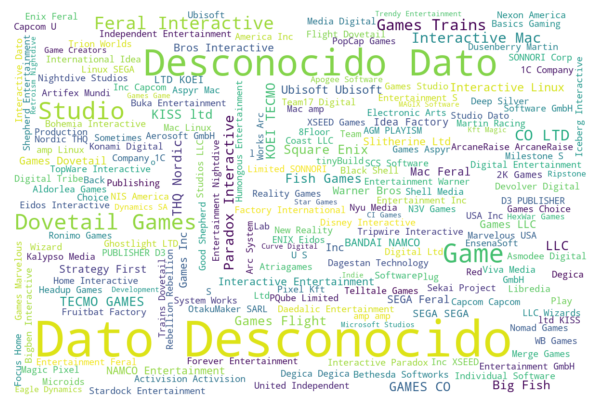

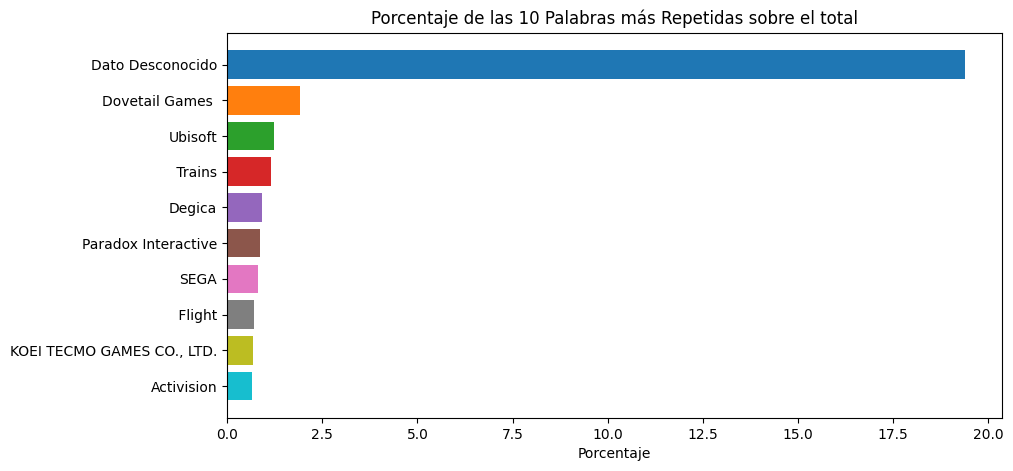

In [111]:
repres_categoricas(df_steam_games, 'publisher')

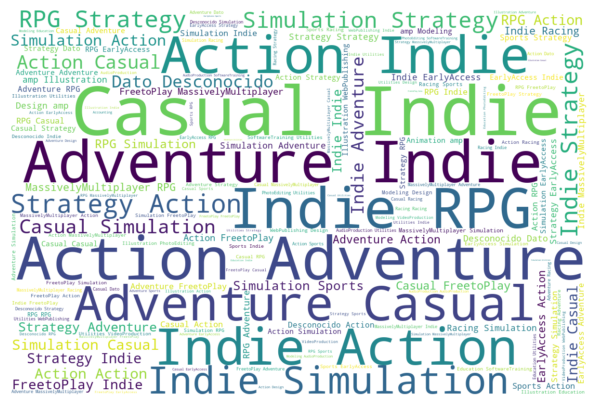

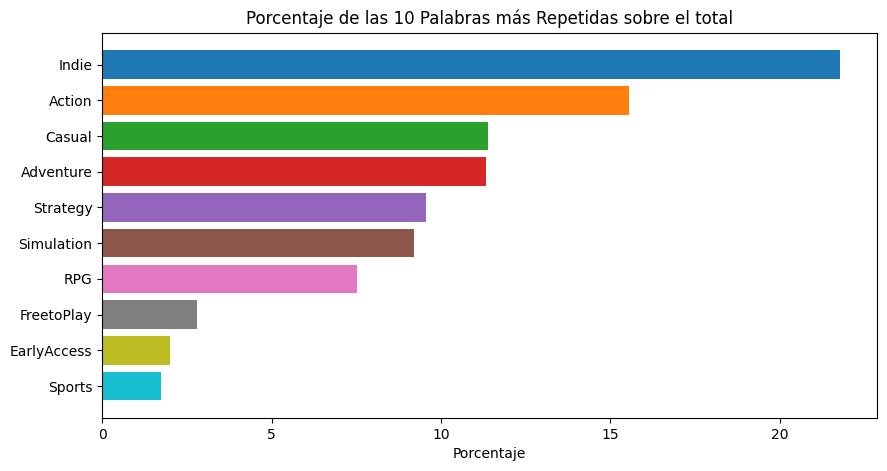

In [112]:
repres_categoricas(df_steam_games, 'genres')

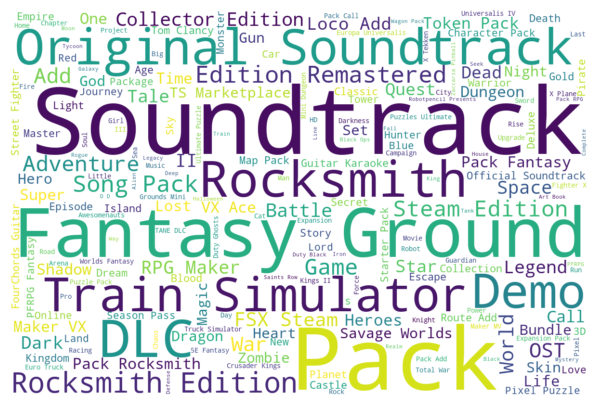

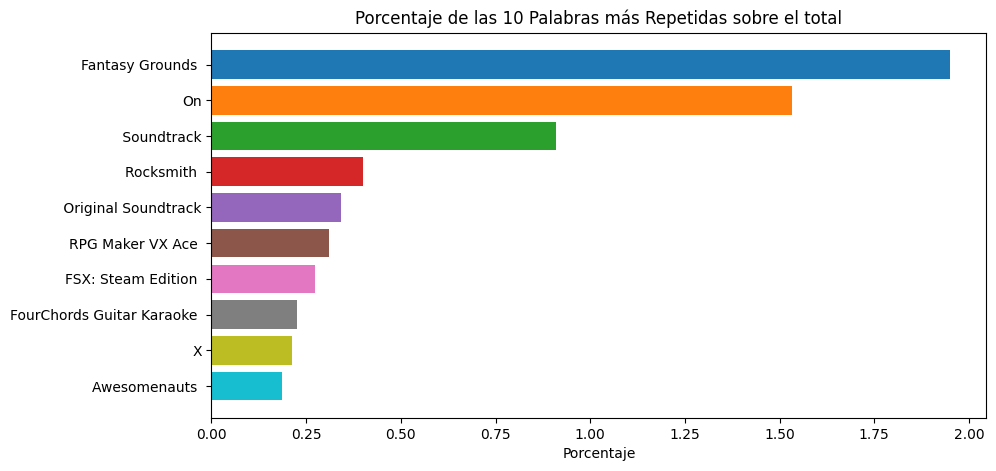

In [113]:
repres_categoricas(df_steam_games, 'app_name')

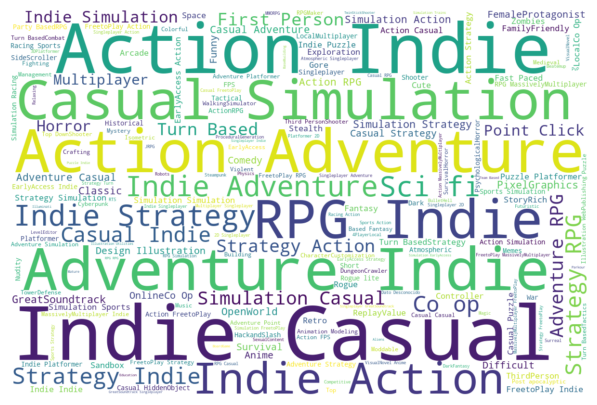

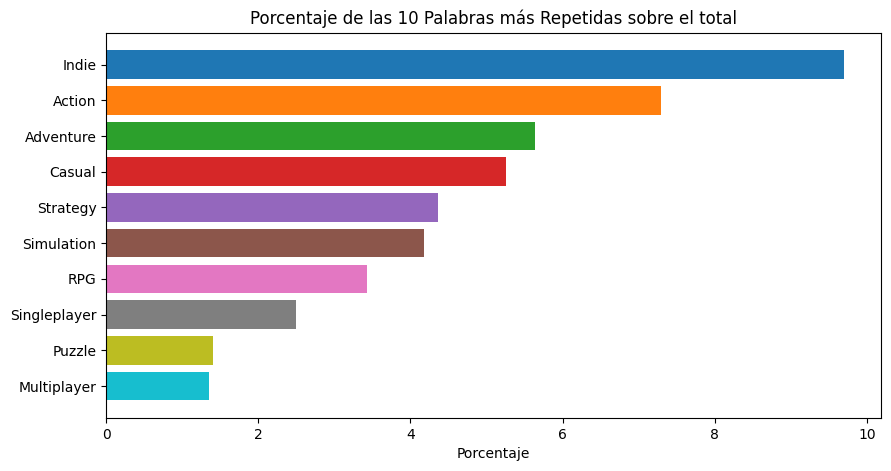

In [114]:
repres_categoricas(df_steam_games, 'tags')

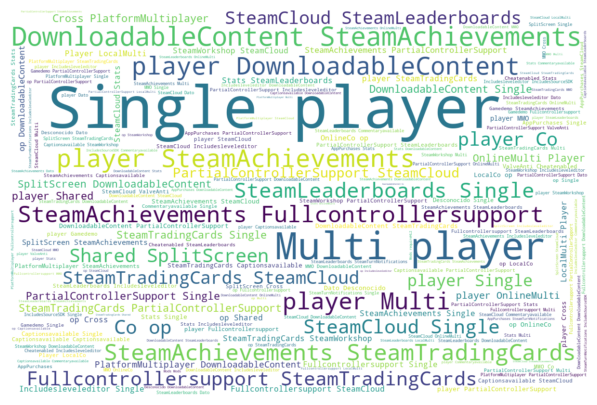

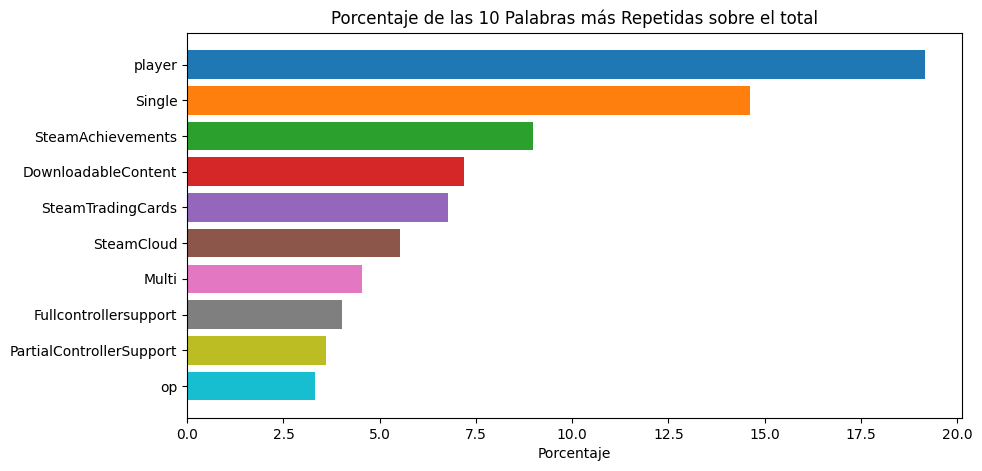

In [115]:
repres_categoricas(df_steam_games, 'specs')

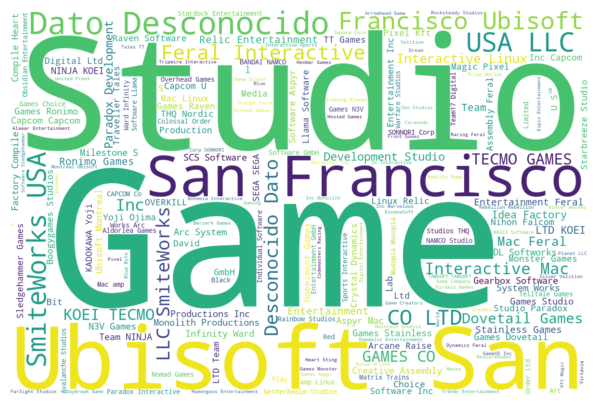

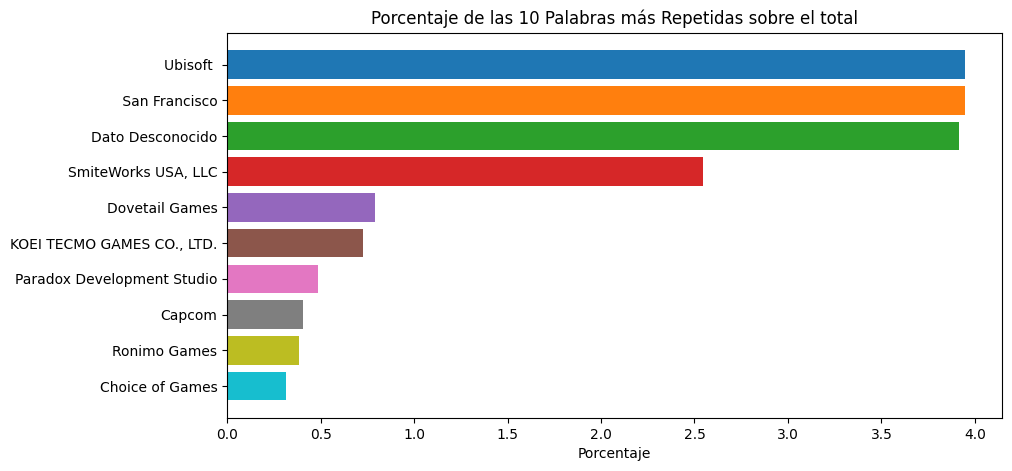

In [116]:
repres_categoricas(df_steam_games, 'developer')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


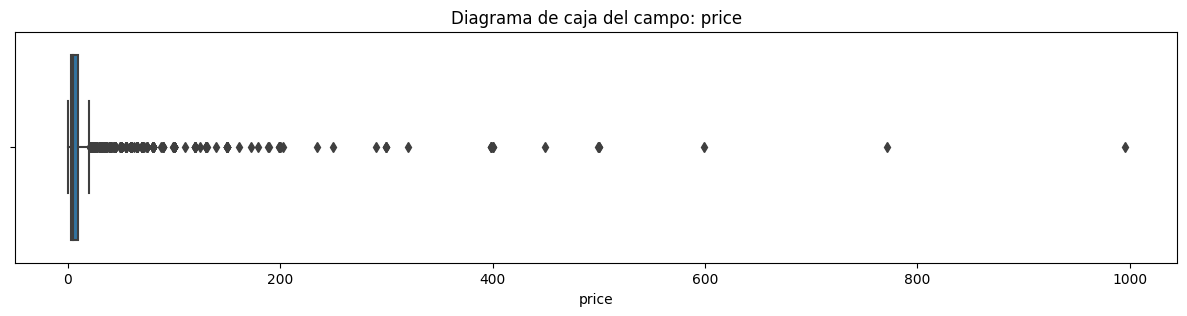

In [117]:
diagrama_caja(df_steam_games, 'price')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


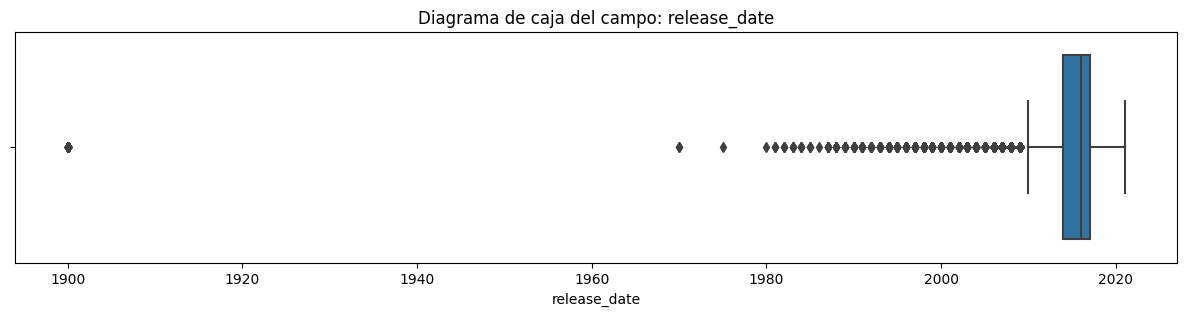

In [118]:
diagrama_caja(df_steam_games, 'release_date')

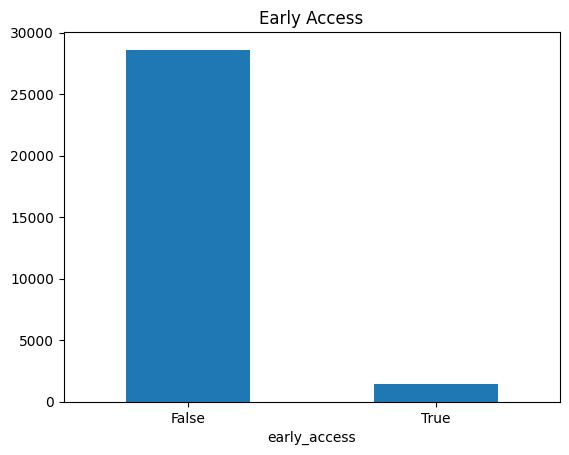

In [119]:
#Grafico de barras que arroja la frecuencia de los valores True y False del campo early_access
frecuencia = df_steam_games['early_access'].value_counts()
frecuencia.plot(kind='bar', rot=0)
plt.title('Early Access')
plt.show()

ANALISIS MULTIVARIABLE

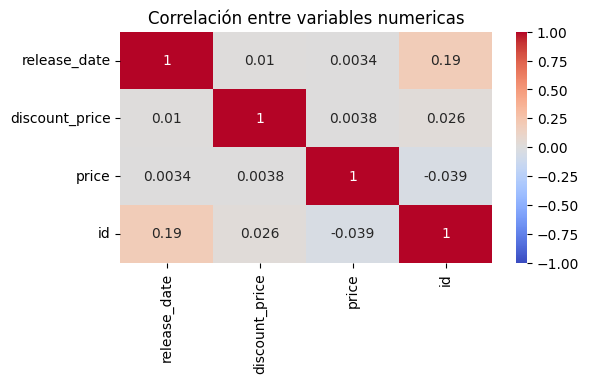

In [120]:
df = df_steam_games.select_dtypes(include=['number'])
matriz_correlacion = df.corr()
plt.figure(figsize=(6, 3))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre variables numericas')
plt.show()

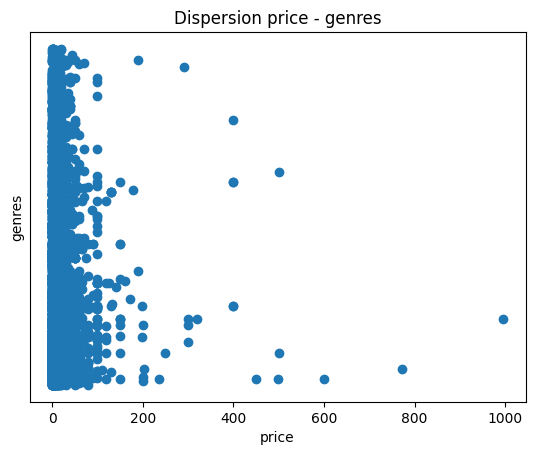

In [121]:
dispersion(df_steam_games, 'price', 'genres')

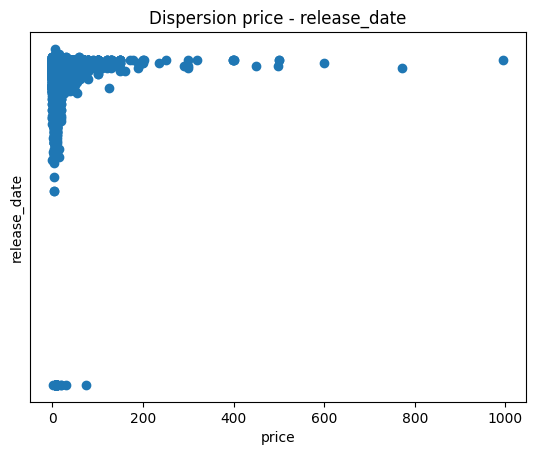

In [122]:
dispersion(df_steam_games, 'price', 'release_date')

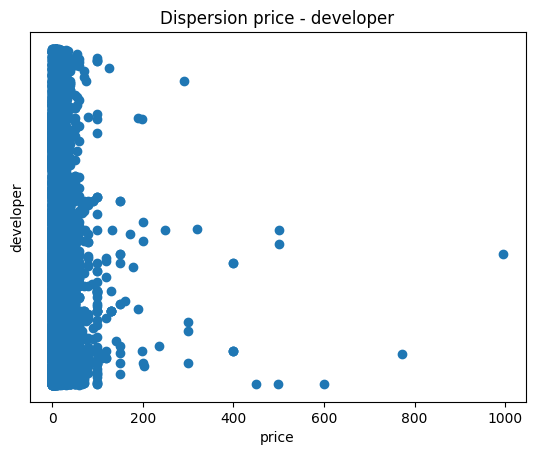

In [123]:
dispersion(df_steam_games, 'price', 'developer')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


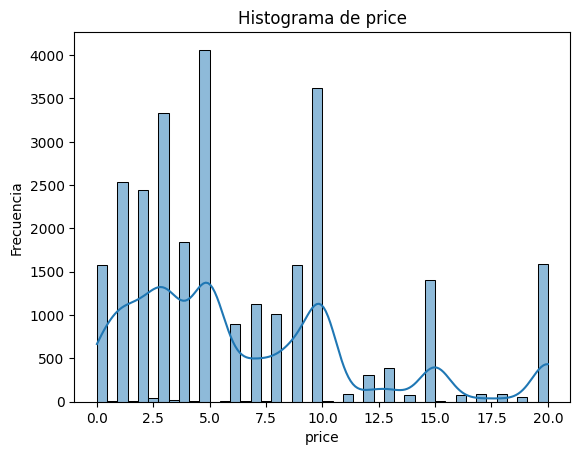

In [124]:
histograma(df_steam_games, 'price')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


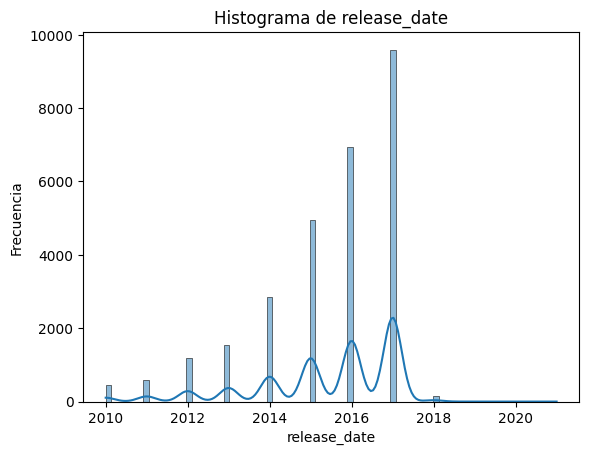

In [125]:
histograma(df_steam_games, 'release_date')

DATASET USER REVIEWS

In [126]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [127]:
imprimir_ejemplos(df_user_reviews, ['reviews'])

reviews :  [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': "It's unique and worth a playthrough."}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]


TRANSFORMACIONES
- Eliminar los campos 'funny' y 'last_edited' por no contener datos.
- Eliminar el campo 'helpful' (util) por ser irrelevante para el analisis que queremos realizar
- Transformar el campo posted a tipo de dato 'date' yyyy-mm-dd.


ETL DATASET USER_REVIEWS

In [128]:
contador = 0
def desanidar(dato):
    global contador
    for diccionario in dato:
        diccionario['user_id'] = df_user_reviews.loc[contador, 'user_id']    
    contador += 1
    return dato
df_user_reviews['reviews'] = df_user_reviews['reviews'].apply(desanidar)

df_lista = []
progress_bar = tqdm(total=len(df_user_reviews['reviews']), desc="Creando Dataframe")
for i in range(len(df_user_reviews['reviews'])):
    dataframe = pd.DataFrame(df_user_reviews.loc[i, 'reviews'])
    df_lista.append(dataframe)
    progress_bar.update(1)

df_reviews = pd.concat(df_lista, ignore_index=True)
progress_bar.close()
df_reviews = df_reviews.drop(columns=['funny', 'last_edited', 'helpful'])
df_reviews['posted'] = df_reviews['posted'].apply(extraer_fecha)
df_reviews['posted'] = pd.to_datetime(df_reviews['posted'], format= '%Y-%m-%d', errors= 'coerce')
df_reviews['posted'].fillna('2010-01-01', inplace= True)
df_reviews['item_id'] = df_reviews['item_id'].astype(int)
df_reviews.to_parquet('user_reviews', index=False)

Creando Dataframe: 100%|██████████| 25799/25799 [00:38<00:00, 671.55it/s] 


In [129]:
df_user_reviews = pd.read_parquet('user_reviews')
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   posted     59305 non-null  datetime64[ns]
 1   item_id    59305 non-null  int32         
 2   recommend  59305 non-null  bool          
 3   review     59305 non-null  object        
 4   user_id    59305 non-null  object        
dtypes: bool(1), datetime64[ns](1), int32(1), object(2)
memory usage: 1.6+ MB


In [130]:
imprimir_ejemplos(df_user_reviews, ['posted', 'item_id', 'recommend', 'review', 'user_id'])

posted :  2011-11-05 00:00:00
item_id :  1250
recommend :  True
review :  Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.
user_id :  76561197970982479


c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


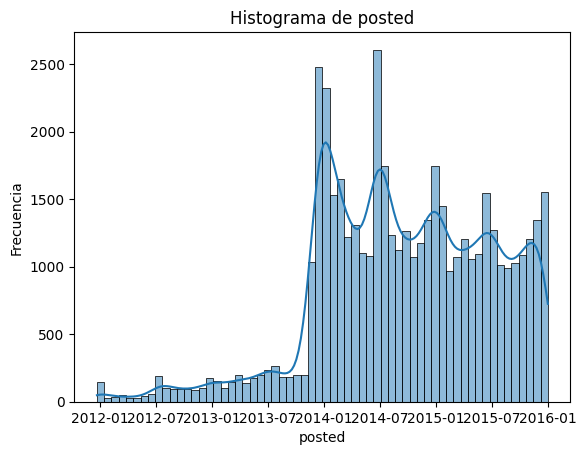

In [131]:
histograma(df_user_reviews, 'posted')

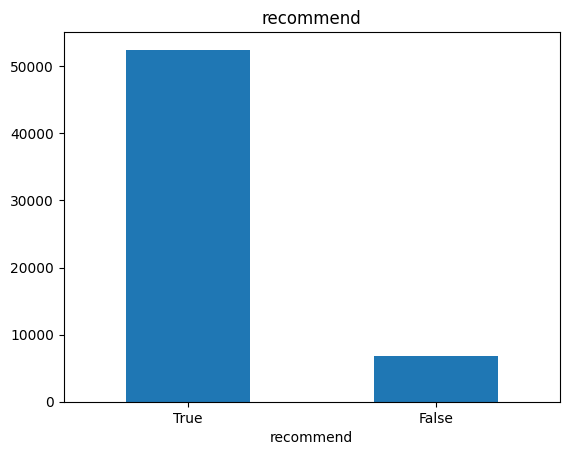

In [132]:
#Grafico de barras que arroja la frecuencia de los valores True y False del campo recommend
frecuencia = df_user_reviews['recommend'].value_counts()
frecuencia.plot(kind='bar', rot=0)
plt.title('recommend')
plt.show()

DF USERS_ITEMS

In [133]:
df_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [134]:
df_users_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [135]:
imprimir_ejemplos(df_users_items, ['user_id', 'items_count', 'steam_id', 'user_url', 'items'])

user_id :  76561197970982479
items_count :  277
steam_id :  76561197970982479
user_url :  http://steamcommunity.com/profiles/76561197970982479
items :  [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_forever': 7, 'playtime_2weeks': 0}, {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '60', 'item_name': 'Ricochet', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '70', 'item_name': 'Half-Life', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '300', 'item_name': 'Day of Defeat: Source', 'playtime_fo

TRANSFORMACIONES
- Eliminar el campo 'steam_id'
- Convertir 'items_count' a int.
- Desanidar el campo 'items'
- Convertir 'item_id' a int
- Convertir 'playtime_forever' a int
- Convertir 'playtime_2weeks' a int

In [136]:
contador = 0
def desanidar(dato):
    global contador
    for diccionario in dato:
        diccionario['user_id'] = df_users_items.loc[contador, 'user_id']
        diccionario['items_count'] = df_users_items.loc[contador, 'items_count']
        diccionario['user_url'] = df_users_items.loc[contador, 'user_url']      
    contador += 1
    return dato
df_users_items['items'] = df_users_items['items'].apply(desanidar)

df_lista = []
progress_bar = tqdm(total=len(df_users_items['items']), desc="Creando Dataframe")
for i in range(len(df_users_items['items'])):
    dataframe = pd.DataFrame(df_users_items.loc[i, 'items'])
    df_lista.append(dataframe)
    progress_bar.update(1)

df_items = pd.concat(df_lista, ignore_index=True)
df_items['item_id'] = df_items['item_id'].astype(int)
df_items['items_count'] = df_items['items_count'].astype(int)
df_items['playtime_forever'] = df_items['playtime_forever'].astype(int)
df_items['playtime_2weeks'] = df_items['playtime_2weeks'].astype(int)
progress_bar.close()
df_items.to_parquet('users_items', index=False)

Creando Dataframe: 100%|██████████| 88310/88310 [03:52<00:00, 380.37it/s]


In [137]:
df_users_items = pd.read_parquet('users_items')
df_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           int32 
 1   item_name         object
 2   playtime_forever  int32 
 3   playtime_2weeks   int32 
 4   user_id           object
 5   items_count       int32 
 6   user_url          object
dtypes: int32(4), object(3)
memory usage: 196.6+ MB


In [138]:
df_users_items.head()

,item_id,item_name,playtime_forever,playtime_2weeks,user_id,items_count,user_url
0,10,Counter-Strike,6,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...


In [139]:
imprimir_ejemplos(df_users_items, ['item_id', 'item_name', 'playtime_forever', 'playtime_2weeks', 'user_id', 'items_count', 'user_url'])

item_id :  10
item_name :  Counter-Strike
playtime_forever :  6
playtime_2weeks :  0
user_id :  76561197970982479
items_count :  277
user_url :  http://steamcommunity.com/profiles/76561197970982479


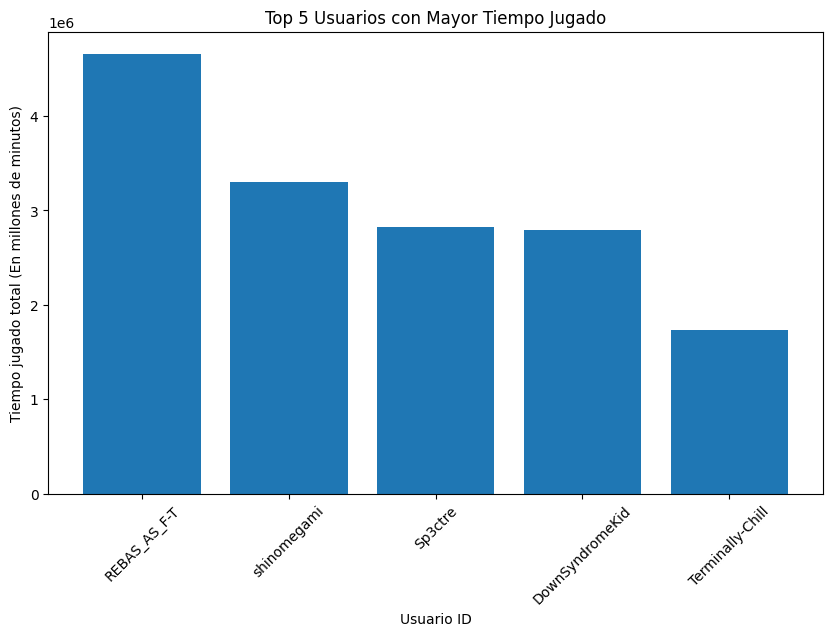

In [140]:
top_5 = df_users_items.groupby('user_id')['playtime_forever'].sum().reset_index().nlargest(5, 'playtime_forever')

plt.figure(figsize=(10, 6))
plt.bar(top_5['user_id'], top_5['playtime_forever'])
plt.xlabel('Usuario ID')
plt.ylabel('Tiempo jugado total (En millones de minutos)')
plt.title('Top 5 Usuarios con Mayor Tiempo Jugado')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x
plt.show()

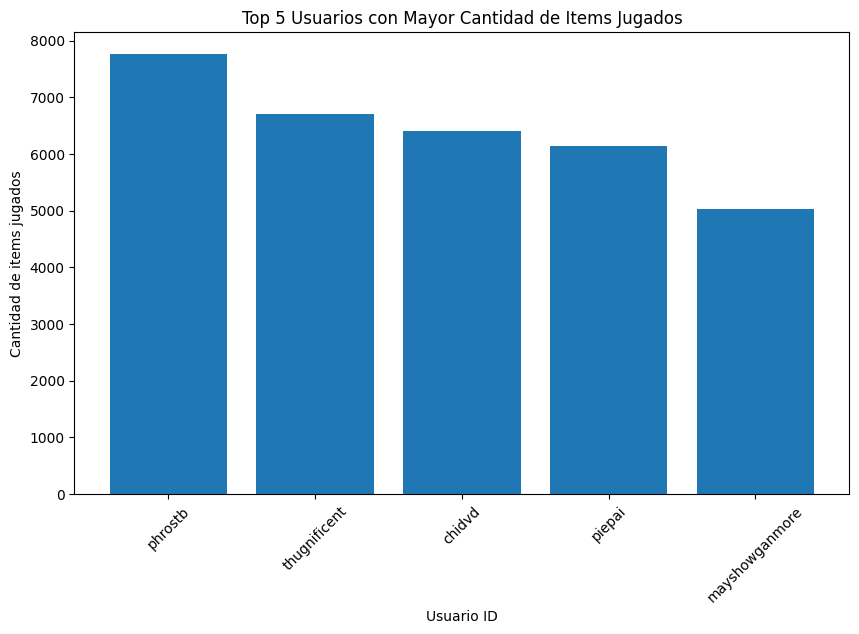

In [141]:
top_5 = df_users_items.groupby('user_id')['items_count'].max().reset_index().nlargest(5, 'items_count')

plt.figure(figsize=(10, 6))
plt.bar(top_5['user_id'], top_5['items_count'])
plt.xlabel('Usuario ID')
plt.ylabel('Cantidad de items jugados')
plt.title('Top 5 Usuarios con Mayor Cantidad de Items Jugados')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x
plt.show()